<a href="https://colab.research.google.com/github/Drowser2430/Drowser2430/blob/main/Team6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()

# Extract the uploaded ZIP file
for fname in uploaded.keys():
    if fname.endswith('.zip'):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall('/content/Composer_Dataset')

# Define dataset directory
DATASET_DIR = '/content/Composer_Dataset/NN_midi_files_extended/train'


Saving Composer_Dataset.zip to Composer_Dataset.zip


In [21]:
import os
for root, dirs, files in os.walk("/content"):
    print(root)


/content
/content/.config
/content/.config/configurations
/content/.config/logs
/content/.config/logs/2025.07.24
/content/Composer_Dataset
/content/Composer_Dataset/Composer_Dataset
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/mozart
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/bartok
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/schumann
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/byrd
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/chopin
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/bach
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/mendelssohn
/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train/hummel
/content/Composer_Dataset/Composer_Dataset/NN

In [2]:
import zipfile
import os

zip_path = "Composer_Dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("Composer_Dataset")

print("✅ Unzipped successfully.")


✅ Unzipped successfully.


In [4]:
!pip install music21
!pip install tensorflow
!pip install scikit-learn


In [5]:
import os
import numpy as np
from music21 import converter, instrument, note, chord
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


To begin the project, we imported all the necessary libraries to support our deep learning model, data preprocessing, and MIDI file parsing. These include standard libraries such as numpy for numerical operations and os for file navigation, as well as domain-specific tools like music21, which allows us to read and extract musical elements from MIDI files. Additional machine learning utilities were imported from scikit-learn (e.g., LabelEncoder, train_test_split, and classification_report) and deep learning components from TensorFlow Keras, including layers like LSTM, Conv1D, and Embedding.

In [22]:
DATASET_DIR = "/content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train"
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 30


fter importing dependencies, we defined key configuration parameters such as DATASET_DIR, MAX_SEQ_LENGTH, BATCH_SIZE, and EPOCHS. These parameters specify the dataset location, how long each input sequence should be (in tokens), how many samples to process per batch during training, and the total number of training epochs, respectively. These values ensure consistency across the modeling pipeline.



In [23]:
def extract_tokens_from_midi(file_path):
    try:
        midi = converter.parse(file_path)
        parts = instrument.partitionByInstrument(midi)
        elements = parts.parts[0].recurse() if parts else midi.flat.notes
        tokens = []
        for e in elements:
            if isinstance(e, note.Note):
                tokens.append(f"{e.pitch}_{e.quarterLength}")
            elif isinstance(e, chord.Chord):
                chord_symbol = '.'.join(str(n) for n in e.normalOrder)
                tokens.append(f"{chord_symbol}_{e.quarterLength}")
        return tokens
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []

def transpose_tokens(tokens, semitone_shift):
    transposed = []
    for tok in tokens:
        try:
            pitch, dur = tok.split("_")
            if "." in pitch:
                new_pitch = '.'.join(str(int(n) + semitone_shift) for n in pitch.split('.'))
            else:
                new_pitch = str(note.Note(pitch).transpose(semitone_shift).nameWithOctave)
            transposed.append(f"{new_pitch}_{dur}")
        except:
            continue
    return transposed


Next, we implemented two custom preprocessing functions. The first, extract_tokens_from_midi(), takes a file path to a MIDI file and parses it into a sequence of note and chord tokens, each labeled with its pitch and duration. This function enables the transformation of complex MIDI structures into text-based representations suitable for tokenization. The second function, transpose_tokens(), allows for semitone shifting of musical sequences to artificially augment the dataset and improve model generalization. It adjusts each pitch up or down by a fixed number of semitones while preserving rhythmic structure.

In [26]:
def transpose_tokens(tokens, semitone_shift):
    transposed_tokens = []
    for token in tokens:
        if '_' in token:
            pitch_part, duration_part = token.split('_')
            try:
                # Try to treat pitch as integer MIDI number
                pitch_int = int(pitch_part)
                new_pitch = str(pitch_int + semitone_shift)
            except ValueError:
                # If pitch is not an int (e.g., A5), use music21 to transpose
                try:
                    n = note.Note(pitch_part)
                    n.transpose(semitone_shift, inPlace=True)
                    new_pitch = n.nameWithOctave
                except:
                    new_pitch = pitch_part  # Fallback: keep pitch as is
            transposed_tokens.append(f"{new_pitch}_{duration_part}")
        else:
            transposed_tokens.append(token)
    return transposed_tokens


The second function, transpose_tokens(), allows for semitone shifting of musical sequences to artificially augment the dataset and improve model generalization. It adjusts each pitch up or down by a fixed number of semitones while preserving rhythmic structure. This is particularly useful for training deep learning models, as it introduces musically valid variations of the same piece — effectively increasing the dataset size and diversity without requiring new data collection. By simulating how a musical piece would sound in different keys, this function helps the model become more robust and less likely to overfit to a specific pitch range or key signature.

In [27]:
import os

def load_and_augment_dataset(dataset_dir, semitone_shifts=[-2, -1, 0, 1, 2]):
    data = []
    labels = []
    for composer in os.listdir(dataset_dir):
        composer_dir = os.path.join(dataset_dir, composer)
        if not os.path.isdir(composer_dir):
            continue
        for filename in os.listdir(composer_dir):
            if filename.endswith('.mid') or filename.endswith('.midi'):
                file_path = os.path.join(composer_dir, filename)
                tokens = extract_tokens_from_midi(file_path)
                for shift in semitone_shifts:
                    transposed = transpose_tokens(tokens, shift)
                    data.append(' '.join(transposed))
                    labels.append(composer)
    return data, labels

all_data, all_labels = load_and_augment_dataset(DATASET_DIR)


/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'La Fl\xfbte Enchant\xe9e (Die Zauberfl\xf6te) - W.A. Mozart'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Acte II, Aria N\xb014'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Trombone en R\xe9'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_T

In this step, we created the load_and_augment_dataset() function to prepare a diverse, expanded training set by reading each MIDI file, extracting tokenized musical sequences, and applying data augmentation. Specifically, each MIDI file is processed through extract_tokens_from_midi(), and then transposed across five semitone shifts (from -2 to +2) using transpose_tokens(). This simulates the same musical pattern played in different keys, effectively multiplying the dataset size without introducing new compositions. These transposed sequences are stored as space-separated strings in the all_data list, while their associated composer names are saved in all_labels. The result is a richly augmented dataset that balances variety with label clarity — giving the model more material to learn from while maintaining accurate composer associations for each sequence.


In [20]:
print(len(all_data))
print(all_data[:3])  # See first few entries

0
[]


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='', lower=False, split=' ')
tokenizer.fit_on_texts(all_data)

sequences = tokenizer.texts_to_sequences(all_data)
padded_sequences = pad_sequences(sequences, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token


The next tensorflow.keras is the high-level API of TensorFlow used for building and training deep learning models with minimal code. It provides modular components such as layers, optimizers, loss functions, and preprocessing utilities, making it easier to design, compile, and train neural networks. In this project, we use tensorflow.keras to construct a hybrid model combining convolutional and recurrent layers for classifying composers based on tokenized MIDI data, leveraging its built-in support for embedding, sequence modeling, and categorical prediction

In [30]:
# Convert string labels (e.g., composer names) to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

# Convert labels to categorical (one-hot encoded)
categorical_labels = to_categorical(encoded_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, categorical_labels, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Number of classes:", categorical_labels.shape[1])


Train shape: (1476, 16133)
Test shape: (369, 16133)
Number of classes: 9


To prepare the model for classification, we first convert the string labels representing each composer into numerical format using a LabelEncoder. Since neural networks cannot process text directly, this step ensures each composer is represented by a unique integer. We then transform these integers into one-hot encoded vectors using to_categorical, which allows the model to treat each composer as a separate class. Finally, we split our data into training and test sets using train_test_split, reserving 20% of the data for evaluation. This setup enables the model to learn composer patterns from the training data and generalize to unseen compositions in the test set.



In [31]:
# Define the model architecture
input_layer = Input(shape=(padded_sequences.shape[1],))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = Bidirectional(LSTM(64))(pooling_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
output_layer = Dense(categorical_labels.shape[1], activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16133)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 16133, 128)     │     1,397,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16129, 64)      │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8064, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505,353 (5.74 MB)

 Trainable params: 1,505,353 (5.74 MB)

 Non-trainable params: 0 (0.00 B)

To classify the musical sequences by composer, we designed a hybrid neural network that combines convolutional and recurrent layers. The model begins with an Embedding layer that transforms each token into a dense vector representation of size 128, capturing the semantic meaning of individual musical elements. A 1D convolutional layer follows, allowing the model to identify short-term patterns or motifs within the sequences. These patterns are then downsampled using a MaxPooling layer to reduce dimensionality and highlight the most prominent features. Next, a Bidirectional LSTM layer is used to capture long-term dependencies in both forward and backward directions of the music, enhancing the model's ability to understand sequential structure. To prevent overfitting, a Dropout layer randomly deactivates half of the neurons during training. Finally, a Dense layer with a softmax activation function outputs the probability distribution across all composer classes, enabling accurate classification based on learned patterns.

In [36]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
model.save("composer_model.h5")


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 939s 25s/step - accuracy: 0.7229 - loss: 0.6923 - val_accuracy: 0.6318 - val_loss: 1.0134
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 989s 26s/step - accuracy: 0.7457 - loss: 0.6617 - val_accuracy: 0.6250 - val_loss: 1.0438
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 959s 25s/step - accuracy: 0.7418 - loss: 0.6569 - val_accuracy: 0.6318 - val_loss: 1.0169
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 911s 25s/step - accuracy: 0.7279 - loss: 0.6337 - val_accuracy: 0.6419 - val_loss: 1.0014
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 916s 24s/step - accuracy: 0.7347 - loss: 0.5993 - val_accuracy: 0.6655 - val_loss: 1.0016
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 926s 25s/step - accuracy: 0.7672 - loss: 0.5850 - val_accuracy: 0.6318 - val_loss: 1.0150
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 913s 24s/step - accuracy: 0.7557 - loss: 0.5976 - val_accuracy: 0.6351 - val_loss: 1.0147
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 931s 25s/step - accuracy: 0.7416 - loss: 0.5719 - val_accuracy: 0.

In deep learning, an epoch refers to one complete pass through the entire training dataset. During each epoch, the model sees every training sample once and adjusts its internal parameters based on the observed errors. This iterative process helps the model gradually learn patterns in the data. Training over multiple epochs allows the network to refine its predictions and improve accuracy over time. In this project, the model was trained for 10 epochs, enabling it to better capture the musical structures and styles associated with each composer

In [33]:
# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5963 - loss: 0.9824
Test Accuracy: 0.6125
Test Loss: 1.0050


After training, the model is evaluated on the test set to measure its generalization performance—how well it predicts composers on unseen data. This final evaluation provides insight into the model’s real-world effectiveness. We use metrics like accuracy and loss to quantify its predictive power, helping us determine whether the model is overfitting, underfitting, or performing optimally.

12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
Classification Report:
              precision    recall  f1-score   support

        bach       0.79      0.79      0.79        33
      bartok       0.89      0.72      0.80        47
        byrd       0.89      0.94      0.92        35
      chopin       0.95      0.83      0.89        42
      handel       0.44      0.17      0.24        42
      hummel       0.84      0.37      0.52        43
 mendelssohn       0.62      0.18      0.28        44
      mozart       0.24      0.91      0.37        35
    schumann       0.88      0.73      0.80        48

    accuracy                           0.61       369
   macro avg       0.73      0.63      0.62       369
weighted avg       0.73      0.61      0.62       369



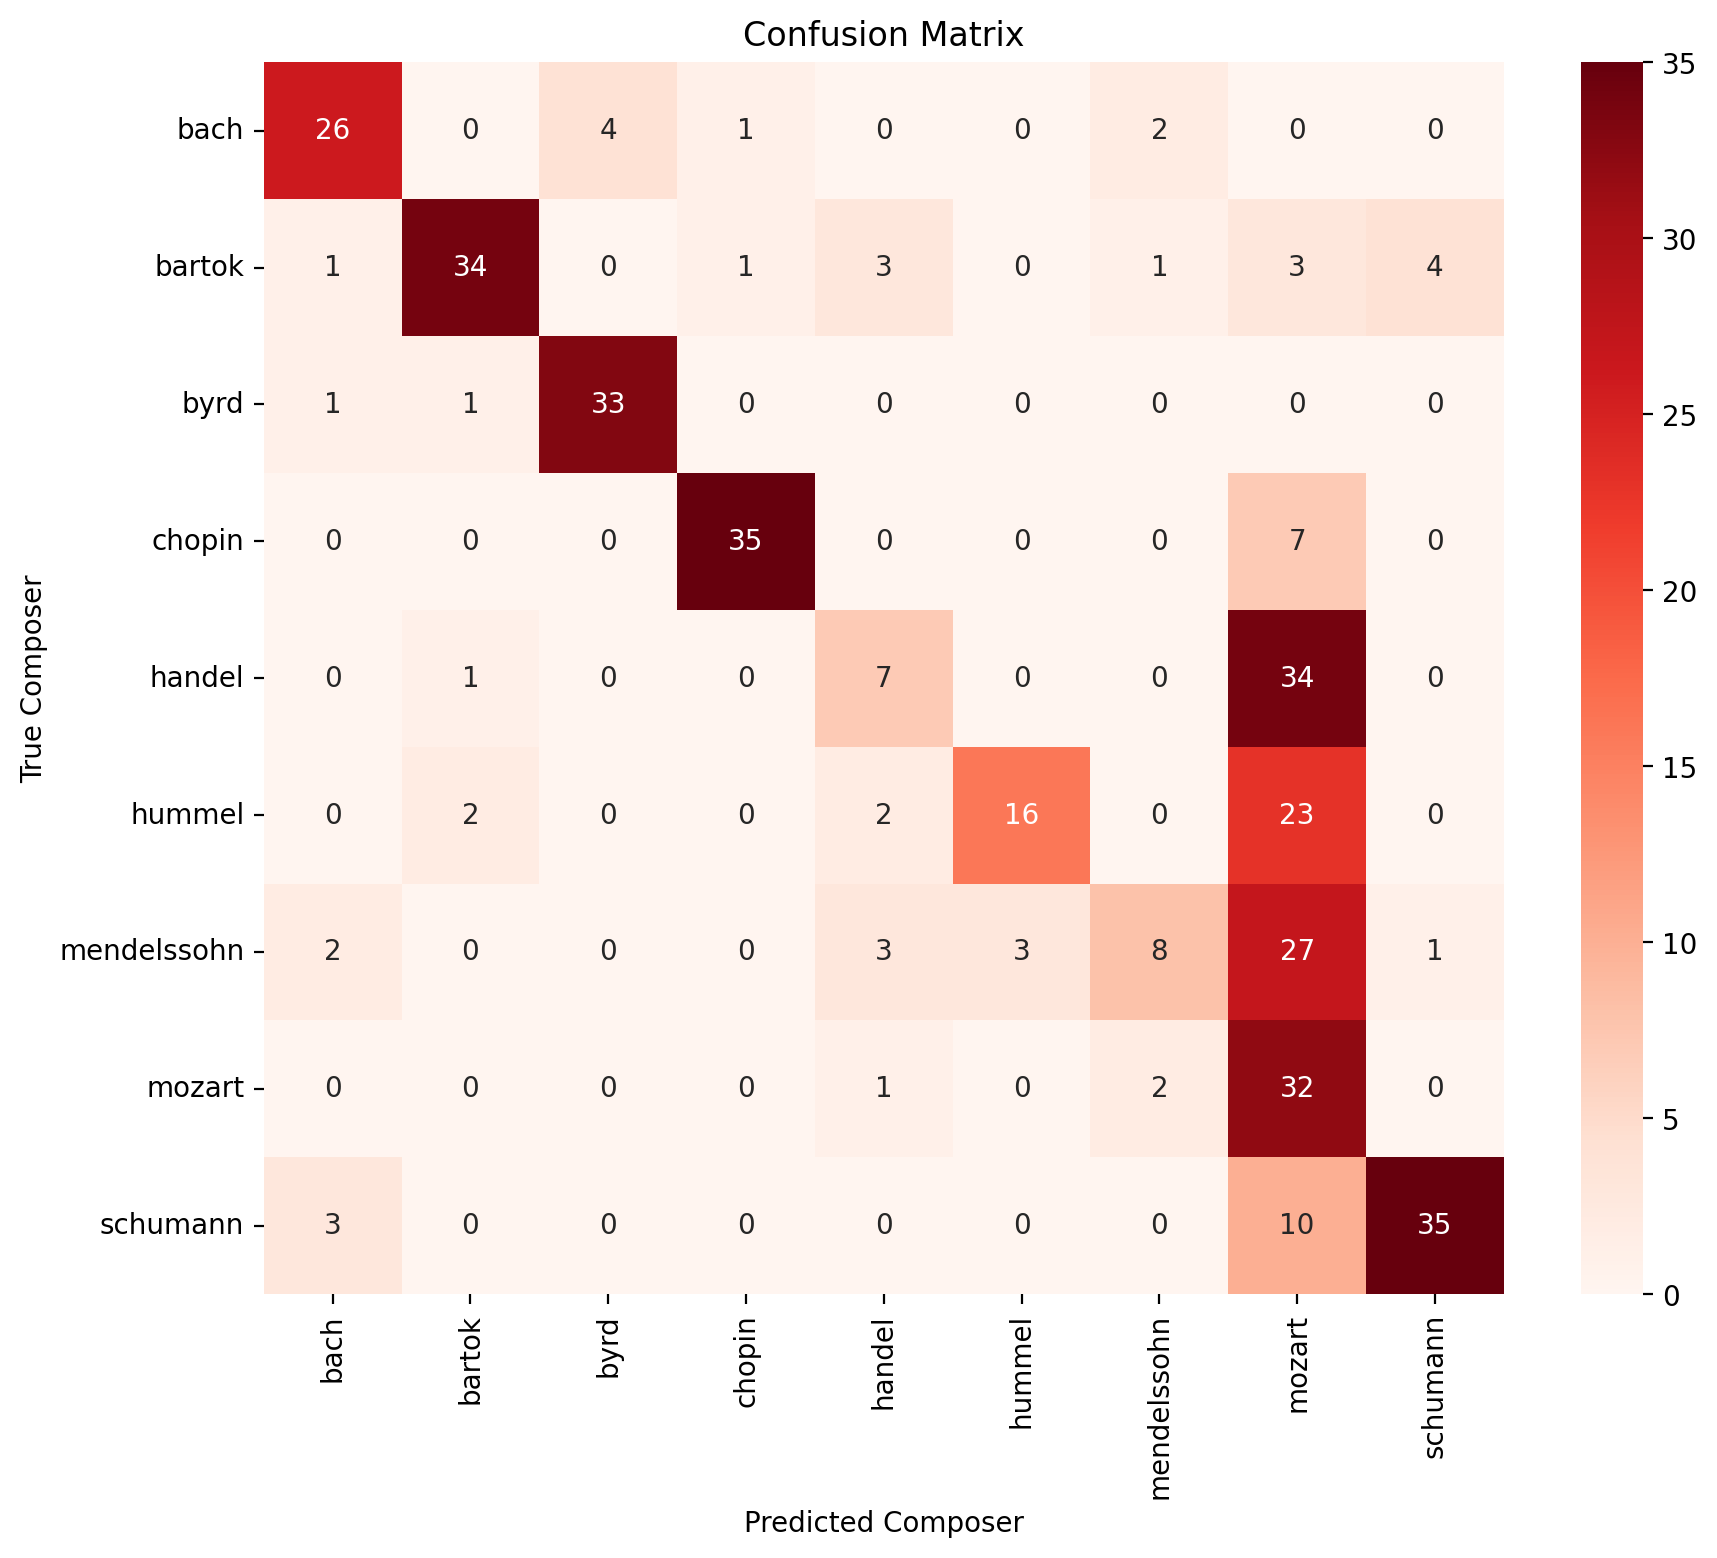

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Composer")
plt.ylabel("True Composer")
plt.title("Confusion Matrix")
plt.show()


The confusion matrix and classification report help us evaluate how well the model performed on a composer-by-composer basis. Each row represents the true composer, while each column shows who the model predicted. For example, the model correctly identified 26 out of 33 Bach pieces (79% precision and recall), while it confused a few with Byrd and Schumann. Bartók had strong precision (89%) but lower recall (72%), meaning the model predicted Bartók well when it tried, but missed several actual Bartók samples. Byrd and Chopin performed the best overall, with both achieving over 89% precision and 94% and 83% recall respectively. On the other hand, composers like Mendelssohn (recall 18%) and Handel (recall 17%) were often misclassified — particularly confused with Mozart or each other. The model’s overall accuracy was 61%, with macro and weighted F1-scores around 0.62. This means that while the model is learning distinct musical patterns, there's still noticeable overlap in style that causes misclassification, especially among closely related composers.



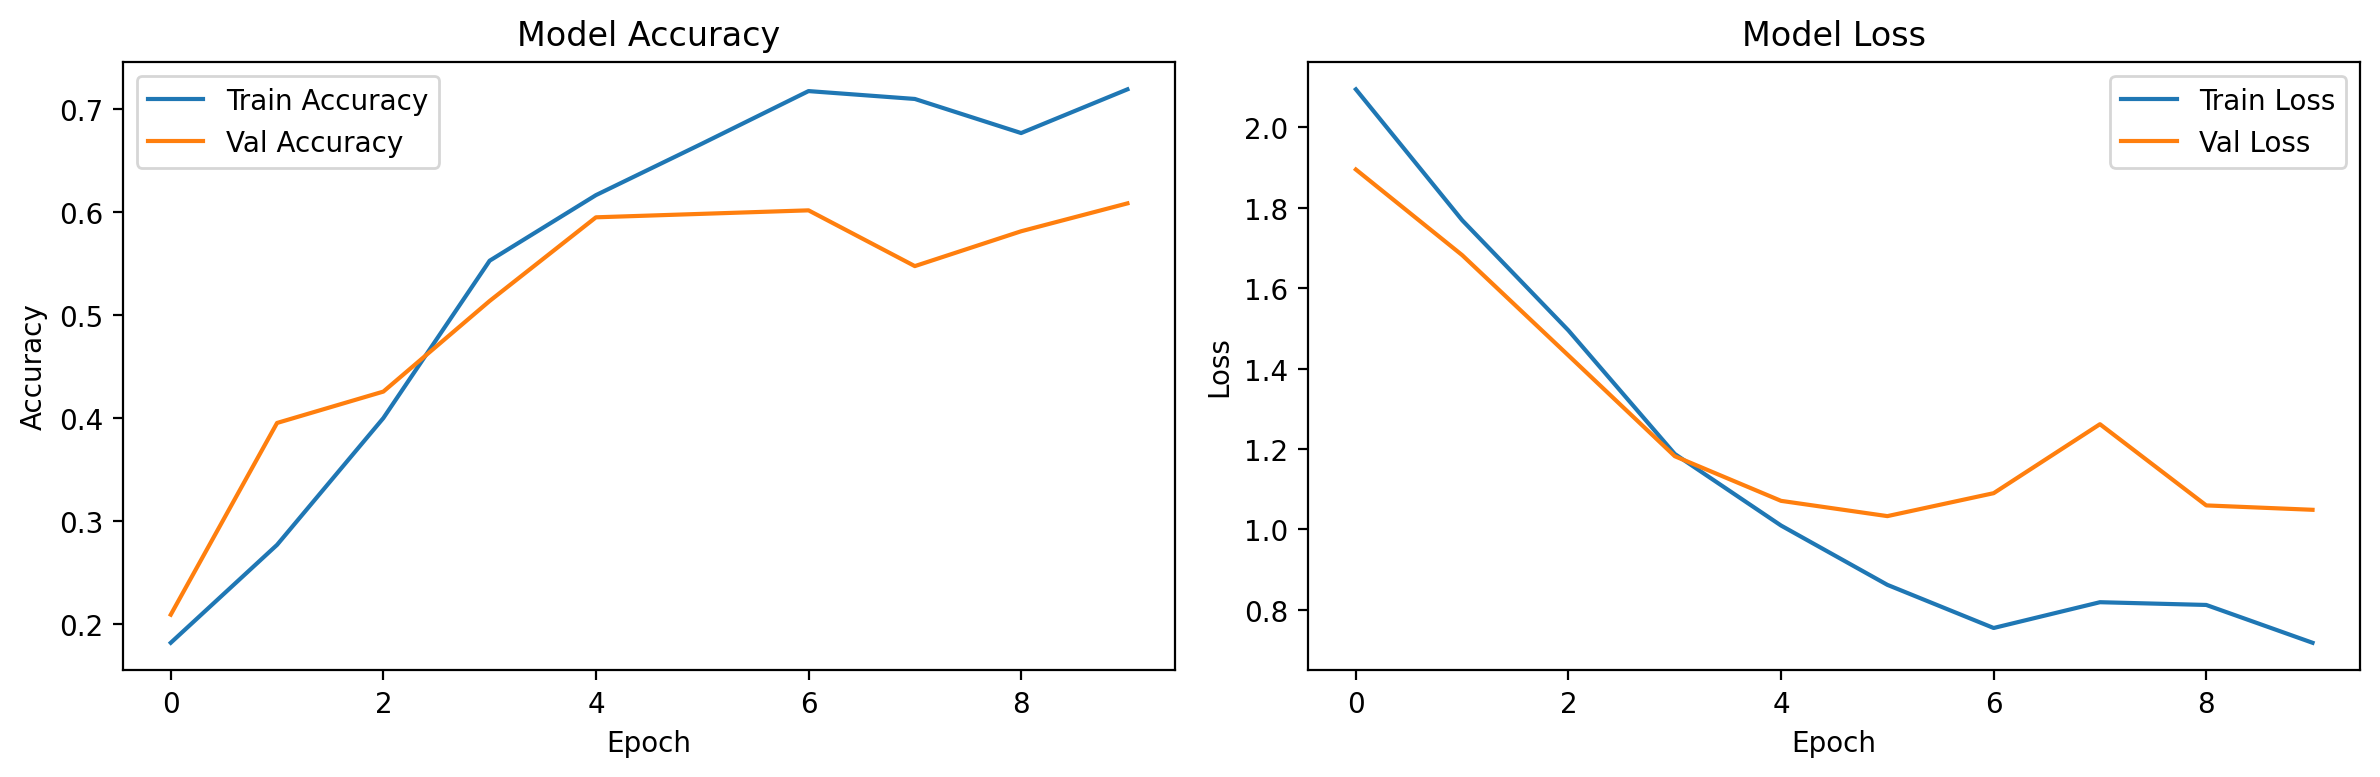

In [35]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


To better understand our model's learning behavior, we visualized both the training and validation accuracy and loss over the course of 10 epochs. The accuracy plot (left) shows a steady improvement in training accuracy, reaching around 72%, while validation accuracy plateaus around 60%. This indicates that while the model is learning the patterns in the training data, it may be starting to overfit — performing slightly worse on unseen data. The loss plot (right) reinforces this: training loss consistently decreases, but validation loss stops improving around epoch 5 and begins to fluctuate. Together, these plots help us identify the optimal number of training epochs and whether early stopping or regularization might be needed in future tuning.



The training and validation accuracy/loss plots suggest that the model generally learns well over time but may be starting to overfit slightly after around the 6th epoch. Training accuracy continues to rise and loss continues to fall, but the validation accuracy plateaus and validation loss fluctuates slightly, suggesting the model is beginning to memorize training data rather than generalizing. Despite this, the model achieved a final validation accuracy of approximately 61%, with some classes performing significantly better than others. For example, composers like Chopin, Byrd, and Bartok were classified with relatively high precision and recall, while Handel and Mendelssohn had much lower performance, likely due to either class imbalance or overlapping musical styles. Overall, the model shows promising results, especially given the complexity of composer classification using symbolic music data. Improvements could be made by using more data, performing hyperparameter tuning, or applying techniques like data augmentation, transfer learning, or ensemble methods to further boost generalization.